Load Data

In [9]:
import torch
from torch_geometric.data import Data
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.append('/Volumes/Lab/Users/bhofflic/cell_classification/src/')
import file_handling
import cell_display_lib as cdl

path ='/Volumes/Scratch/Users/bhofflic/cell_correlations/gnn_data/'

Load Data

In [170]:
# Load all pickle files in path
import glob
import pickle

data = pd.DataFrame()
files = glob.glob(path+'*.pkl')
for file in tqdm(files):
    with open(file, 'rb') as f:
        data = pd.concat([data,pickle.load(f)])

100%|██████████| 18/18 [02:54<00:00,  9.68s/it]


Preprocessing

In [171]:
# Define the ruleout types
ruleout = ['BW', 'unlabel', 'weird', 'duplicate', 'unclass', 'contaminated', 'crap', 'edge', 'weak', 'mess', 'Unclass', 'artifact']

# Preprocessing: Filter out unwanted cell types
# Create a mask for valid cell types
labels = data['label'].values
valid_cell_mask = ~np.isin(labels, ruleout)
all_data = data[valid_cell_mask]

In [172]:
focus_types = ['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget', 'SBC', 'ON smooth', 'OFF smooth']
data = all_data.query('label in @focus_types')

In [174]:
acfs = data['acf'].values
acfs = np.array([np.array(acf.a) for acf in acfs])
tcs = data['tc'].values
tcs = np.array([tc.a for tc in tcs])
tcs = tcs.reshape(tcs.shape[0],-1)
for i,tc in enumerate(tcs):
    tcs[i] /= np.max(tc)
tcs_all = data['tc_all'].values
tcs_all = np.array([tc.a for tc in tcs_all])
tcs_all = tcs_all.reshape(tcs_all.shape[0],-1)
for i,tc in enumerate(tcs_all):
    tcs_all[i] /= np.max(tc)
original_cch_shapes = [cch.a.shape for cch in data['cch_1ms'].values]
cch_1ms = data['cch_1ms'].values
cch_1ms = np.vstack([np.array(cch.a) for cch in cch_1ms])
cch_10ms = data['cch_10ms'].values
cch_10ms = np.vstack([np.array(cch.a) for cch in cch_10ms])
spike_waveforms = data['spike_waveform'].values
spike_waveforms = np.array([np.array(swf.a) for swf in spike_waveforms])

In [175]:
#perform PCA on the data
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
acf_pca = pca.fit_transform(acfs)
tc_pca = pca.fit_transform(tcs)
tc_all_pca = pca.fit_transform(tcs_all)
cch_1ms_pca = pca.fit_transform(cch_1ms)
cch_10ms_pca = pca.fit_transform(cch_10ms)
spike_waveforms_pca = pca.fit_transform(spike_waveforms)

In [197]:
#Plot TSNE of the data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

rf_sizes = np.sqrt(data['size'].values/np.pi)
spike_counts = data['spike_count'].values
acf_tc_tsne = tsne.fit_transform(np.hstack([acf_pca,tc_pca, tc_all_pca]))

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


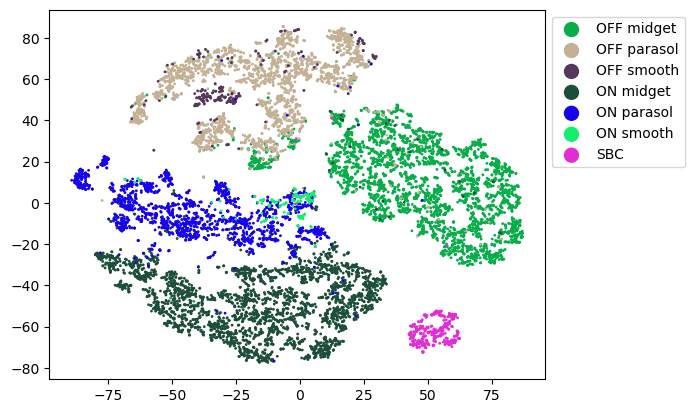

In [198]:
def generate_unique_color():
    return np.random.rand(3,)

labels = data['label'].values
label_colors = {label: generate_unique_color() for label in np.unique(labels)}
colors = np.array([label_colors[i] for i in labels])

for i,label in enumerate(np.unique(labels)):
    plt.scatter(acf_tc_tsne[labels==label,0],acf_tc_tsne[labels==label,1],s=1,c=colors[labels==label], label=label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),markerscale=10)

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


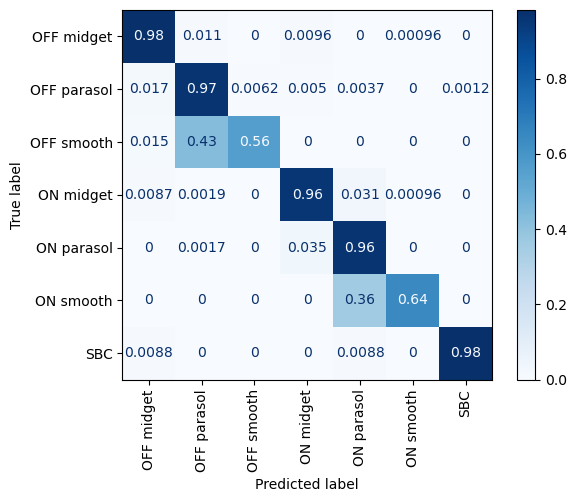

In [194]:
#SVM classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.hstack([acf_pca,tc_pca, tc_all_pca]), labels, test_size=0.33, random_state=42)

#Train the SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

#Test the SVM
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', xticks_rotation='vertical')



In [213]:
original_cch_shapes = [cch.a.shape for cch in data['cch_1ms'].values]
reconstructed_1ms_pcs = []
reconstructed_10ms_pcs = []
current_index = 0
for shape in original_cch_shapes:
    num_elements = shape[0]
    
    segment = cch_1ms_pca[current_index:current_index + num_elements]
    matrix = segment.reshape(shape[0], -1)
    reconstructed_1ms_pcs.append(matrix)
    
    segment = cch_10ms_pca[current_index:current_index + num_elements]
    matrix = segment.reshape(shape[0], -1)
    reconstructed_10ms_pcs.append(matrix)
    
    # Update the index for the next segment
    current_index += num_elements

In [229]:
from file_handling import wrapper
pc_data = {'piece_id': data['piece_id'].values,
           'run_id': data['run_id'].values,
           'unit_id': data['unit_id'].values,
           'tc': [wrapper(tc) for tc in tc_pca], 
           'tc_all': [wrapper(tc) for tc in tc_all_pca], 
           'acf': [wrapper(acf) for acf in acf_pca],
           'cch_1ms': [wrapper(cch) for cch in reconstructed_1ms_pcs],
           'cch_10ms': [wrapper(cch) for cch in reconstructed_10ms_pcs],
           'spike_waveform': [wrapper(swf) for swf in spike_waveforms_pca],
           'label': labels, 
           'rf_size': rf_sizes, 
           'spike_count': spike_counts,
           'distance': data['distances'].values,
           'overlap': data['overlaps'].values,
           'cch_ids': data['cch_ids'].values,}
gnn_data = pd.DataFrame(pc_data)

In [274]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

edge_tsne = tsne.fit_transform(np.array(edge_features))

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


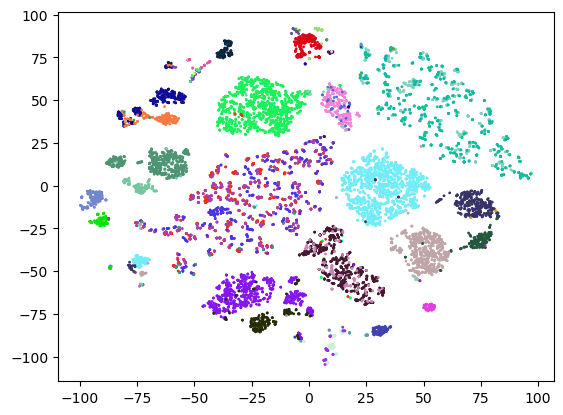

In [275]:
def generate_unique_color():
    return np.random.rand(3,)

labels = edge_labels
label_colors = {tuple(label): generate_unique_color() for label in np.unique(labels, axis=0)}
colors = np.array([label_colors[i] for i in labels])

for i,label in enumerate(np.unique(labels, axis=0)):
    mask = np.all(labels == label, axis=1)
    filtered_edge_tsne = edge_tsne[mask]
    plt.scatter(filtered_edge_tsne[:,0],filtered_edge_tsne[:,1],s=1,c=colors[mask], label=label)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1),markerscale=10)

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


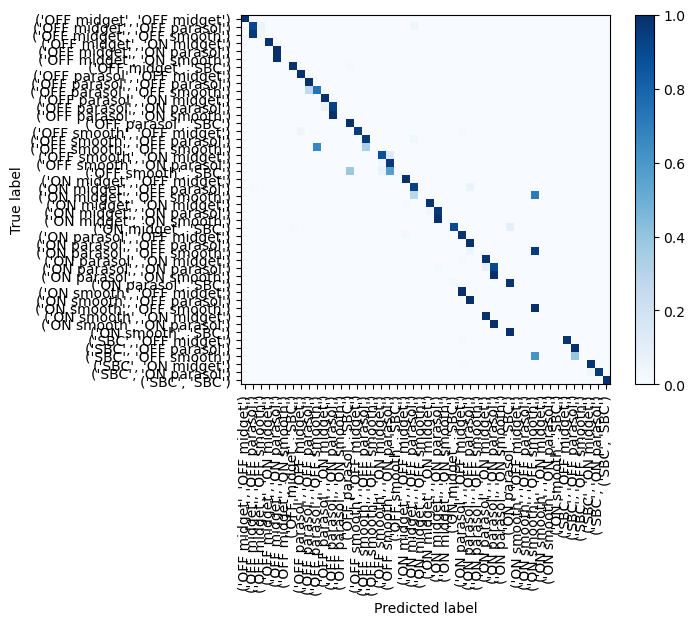

In [280]:
#SVM classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Split the data into training and testing sets
#convert labels to strings
edge_labels = np.array([str(label) for label in edge_labels])
    
X_train, X_test, y_train, y_test = train_test_split(edge_features, edge_labels, test_size=0.95, random_state=42)

#Train the SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

#Test the SVM
y_pred = clf.predict(X_test)

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, xticks_rotation='vertical', include_values=False, normalize='true')


In [278]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9915946205571565

Visualize Graph Structure

In [284]:
edges = []
edge_features = []
edge_labels = []
piece_id = gnn_data['piece_id'].unique()[0]
piece_gnn_data = gnn_data.query('piece_id == @piece_id')
for i in range(piece_gnn_data.shape[0]):
    for j in range(i+1, piece_gnn_data.shape[0]):
        if piece_gnn_data['distance'].values[i].a[j] < 3:
            edges.append([i,j])
            edge_features.append(np.hstack([piece_gnn_data['distance'].values[i].a[j], 
                                            piece_gnn_data['overlap'].values[i].a[j], 
                                            piece_gnn_data['cch_1ms'].values[i].a[j], 
                                            piece_gnn_data['cch_10ms'].values[i].a[j]]))
            edge_labels.append((piece_gnn_data['label'].values[i], piece_gnn_data['label'].values[j]))

In [288]:
#create a neat networkx graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiGraph()
# Assuming the number of nodes is the shape of valid_cell_dists
num_nodes = len(piece_gnn_data)
G.add_nodes_from(range(num_nodes))
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        distance = piece_gnn_data['distance'].values[i].a[j]
        if distance > 3:
            continue
        edge_type = 'nonsurround' if distance < 1.5 else 'surround'
        edge_attributes = {
            'dist': distance,
            'edge_type': edge_type,
        }
        G.add_edge(i, j, **edge_attributes)

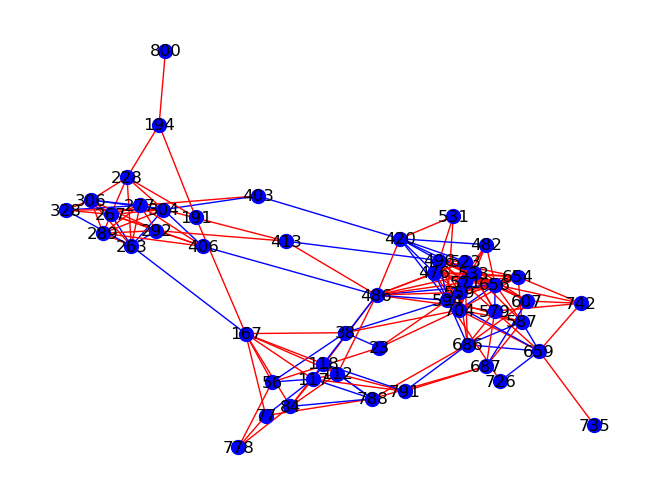

In [291]:
# Define colors for different edge types
edge_colors = {
    'surround': 'red',
    'nonsurround': 'blue'
}

# Create a list of edge colors based on edge types
edge_color_list = [edge_colors[G[u][v][0]['edge_type']] for u, v in G.edges()]

subgraph = G.subgraph(np.random.choice(G.nodes, 50, replace=False))
pos = nx.spring_layout(subgraph)
options = {
    'with_labels': True,
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
    'edge_color': edge_color_list,
}
nx.draw(subgraph, pos, **options)

Create PyG Model

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.optim as optim

class EdgeTypeAwareConv(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_attr_dim, num_relations):
        super(EdgeTypeAwareConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_attr_dim = edge_attr_dim
        self.num_relations = num_relations

        # Linear transformations for edge types
        self.edge_transforms = nn.ModuleList([
            nn.Linear(edge_attr_dim, out_channels) for _ in range(num_relations)
        ])

        # Linear transformation for node features
        self.node_transformation = nn.Linear(in_channels, out_channels, bias=False)

        # Linear transformation for combined node and edge attributes
        self.combined_transform = nn.Linear(out_channels + out_channels, out_channels)

    def forward(self, x, edge_index, edge_type, edge_attr):
        # Add self-loops to the adjacency matrix
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Apply linear transformation to node features
        x = self.node_transformation(x)
        
        # Start message passing
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_type=edge_type, edge_attr=edge_attr)

    def message(self, x_j, edge_index_i, edge_type, edge_attr):
        # Initialize tensor to store transformed edge attributes
        # Shape: [number of edges, out_channels]
        transformed_edge_attr = torch.zeros((edge_attr.size(0), self.out_channels), device=edge_attr.device)

        # Apply transformations for each edge type
        for rel_type in range(self.num_relations):
            mask = edge_type == rel_type
            if mask.any():
                transformed_edge_attr[mask] = self.edge_transforms[rel_type](edge_attr[mask])

        # Concatenate the node features with the transformed edge attributes
        # Here, x_j and transformed_edge_attr both have a size of [number of edges, feature size]
        combined_features = torch.cat([x_j, transformed_edge_attr], dim=-1)
        return self.combined_transform(combined_features)

class RGCN(nn.Module):
    def __init__(self, num_node_features, num_relations, num_classes, edge_attr_dim):
        super(RGCN, self).__init__()
        self.conv1 = EdgeTypeAwareConv(num_node_features, 64, edge_attr_dim, num_relations)
        self.conv2 = EdgeTypeAwareConv(64, num_classes, edge_attr_dim, num_relations)

    def forward(self, data):
        x, edge_index, edge_type, edge_attr = data.x, data.edge_index, data.edge_type, data.edge_attr

        x = F.relu(self.conv1(x, edge_index, edge_type, edge_attr))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_type, edge_attr)

        return F.log_softmax(x, dim=1)

Device: cuda, 0


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 7/10000 [00:00<02:43, 61.09it/s]

Epoch: 000, Loss: 38.6821, Train Acc: 0.1993, Val Acc: 0.0571


  1%|          | 112/10000 [00:01<02:39, 62.06it/s]

Epoch: 100, Loss: 2.0353, Train Acc: 0.2622, Val Acc: 0.2000


  2%|▏         | 211/10000 [00:03<02:33, 63.73it/s]

Epoch: 200, Loss: 1.9923, Train Acc: 0.3427, Val Acc: 0.2286


  3%|▎         | 309/10000 [00:04<02:37, 61.57it/s]

Epoch: 300, Loss: 1.9789, Train Acc: 0.4091, Val Acc: 0.2286


  4%|▍         | 407/10000 [00:06<02:36, 61.16it/s]

Epoch: 400, Loss: 1.9182, Train Acc: 0.4126, Val Acc: 0.2857


  5%|▌         | 512/10000 [00:08<02:39, 59.67it/s]

Epoch: 500, Loss: 2.0321, Train Acc: 0.3077, Val Acc: 0.2857


  6%|▌         | 609/10000 [00:09<02:33, 61.14it/s]

Epoch: 600, Loss: 1.8433, Train Acc: 0.4196, Val Acc: 0.3429


  7%|▋         | 707/10000 [00:11<02:32, 61.09it/s]

Epoch: 700, Loss: 1.8389, Train Acc: 0.4301, Val Acc: 0.2000


  8%|▊         | 812/10000 [00:13<02:33, 59.94it/s]

Epoch: 800, Loss: 1.7975, Train Acc: 0.3741, Val Acc: 0.3429


  9%|▉         | 910/10000 [00:14<02:26, 62.13it/s]

Epoch: 900, Loss: 1.7135, Train Acc: 0.4441, Val Acc: 0.3714


 10%|█         | 1008/10000 [00:16<02:26, 61.46it/s]

Epoch: 1000, Loss: 1.8195, Train Acc: 0.4825, Val Acc: 0.3429


 11%|█         | 1113/10000 [00:18<02:25, 61.06it/s]

Epoch: 1100, Loss: 1.8540, Train Acc: 0.4441, Val Acc: 0.3429


 12%|█▏        | 1211/10000 [00:19<02:20, 62.58it/s]

Epoch: 1200, Loss: 4.0723, Train Acc: 0.1608, Val Acc: 0.2000


 13%|█▎        | 1312/10000 [00:21<02:04, 70.03it/s]

Epoch: 1300, Loss: 1.5680, Train Acc: 0.5315, Val Acc: 0.4000


 14%|█▍        | 1411/10000 [00:22<01:43, 83.15it/s]

Epoch: 1400, Loss: 1.6035, Train Acc: 0.5804, Val Acc: 0.4286


 15%|█▌        | 1516/10000 [00:23<01:32, 92.15it/s]

Epoch: 1500, Loss: 1.6655, Train Acc: 0.4825, Val Acc: 0.3429


 16%|█▌        | 1617/10000 [00:24<01:26, 97.04it/s]

Epoch: 1600, Loss: 2.3428, Train Acc: 0.4545, Val Acc: 0.2286


 17%|█▋        | 1711/10000 [00:25<01:27, 94.30it/s]

Epoch: 1700, Loss: 1.7992, Train Acc: 0.2203, Val Acc: 0.2286


 18%|█▊        | 1820/10000 [00:26<01:21, 100.52it/s]

Epoch: 1800, Loss: 1.4418, Train Acc: 0.5664, Val Acc: 0.4286


 19%|█▉        | 1911/10000 [00:27<01:28, 91.74it/s] 

Epoch: 1900, Loss: 1.5928, Train Acc: 0.4476, Val Acc: 0.4286


 20%|██        | 2016/10000 [00:28<01:20, 99.19it/s]

Epoch: 2000, Loss: 3.9809, Train Acc: 0.3776, Val Acc: 0.2000


 21%|██        | 2120/10000 [00:29<01:18, 100.33it/s]

Epoch: 2100, Loss: 1.3686, Train Acc: 0.6259, Val Acc: 0.4857


 22%|██▏       | 2219/10000 [00:30<01:16, 101.31it/s]

Epoch: 2200, Loss: 1.4250, Train Acc: 0.5874, Val Acc: 0.4000


 23%|██▎       | 2313/10000 [00:31<01:18, 97.41it/s] 

Epoch: 2300, Loss: 1.4081, Train Acc: 0.5559, Val Acc: 0.4000


 24%|██▍       | 2413/10000 [00:32<01:20, 94.67it/s]

Epoch: 2400, Loss: 1.6133, Train Acc: 0.5699, Val Acc: 0.4000


 25%|██▌       | 2520/10000 [00:33<01:16, 97.18it/s] 

Epoch: 2500, Loss: 1.2761, Train Acc: 0.4930, Val Acc: 0.3714


 26%|██▌       | 2613/10000 [00:34<01:15, 98.38it/s]

Epoch: 2600, Loss: 1.9635, Train Acc: 0.3741, Val Acc: 0.2286


 27%|██▋       | 2715/10000 [00:35<01:15, 96.02it/s]

Epoch: 2700, Loss: 4.7328, Train Acc: 0.2727, Val Acc: 0.2000


 28%|██▊       | 2811/10000 [00:36<01:11, 100.65it/s]

Epoch: 2800, Loss: 1.2107, Train Acc: 0.6329, Val Acc: 0.4857


 29%|██▉       | 2921/10000 [00:37<01:09, 101.31it/s]

Epoch: 2900, Loss: 1.3043, Train Acc: 0.6259, Val Acc: 0.4857


 30%|███       | 3014/10000 [00:38<01:10, 99.45it/s] 

Epoch: 3000, Loss: 1.8189, Train Acc: 0.4056, Val Acc: 0.2286


 31%|███       | 3117/10000 [00:39<01:08, 99.87it/s]

Epoch: 3100, Loss: 1.4050, Train Acc: 0.6189, Val Acc: 0.4571


 32%|███▏      | 3219/10000 [00:40<01:08, 99.57it/s]

Epoch: 3200, Loss: 1.1473, Train Acc: 0.6643, Val Acc: 0.5143


 33%|███▎      | 3315/10000 [00:41<01:07, 99.37it/s] 

Epoch: 3300, Loss: 9.1260, Train Acc: 0.2028, Val Acc: 0.1429


 34%|███▍      | 3416/10000 [00:42<01:08, 96.10it/s]

Epoch: 3400, Loss: 78.1053, Train Acc: 0.1538, Val Acc: 0.2286


 35%|███▌      | 3518/10000 [00:44<01:07, 96.01it/s]

Epoch: 3500, Loss: 1.7119, Train Acc: 0.4615, Val Acc: 0.2571


 36%|███▌      | 3613/10000 [00:44<01:05, 97.48it/s] 

Epoch: 3600, Loss: 1.4558, Train Acc: 0.5874, Val Acc: 0.4286


 37%|███▋      | 3713/10000 [00:46<01:04, 97.68it/s]

Epoch: 3700, Loss: 1.3630, Train Acc: 0.6119, Val Acc: 0.4857


 38%|███▊      | 3817/10000 [00:47<01:01, 100.73it/s]

Epoch: 3800, Loss: 1.3020, Train Acc: 0.6224, Val Acc: 0.5143


 39%|███▉      | 3912/10000 [00:48<01:02, 97.56it/s] 

Epoch: 3900, Loss: 1.2553, Train Acc: 0.6189, Val Acc: 0.5143


 40%|████      | 4015/10000 [00:49<01:00, 98.92it/s]

Epoch: 4000, Loss: 1.2163, Train Acc: 0.6364, Val Acc: 0.5143


 41%|████      | 4118/10000 [00:50<01:00, 96.89it/s]

Epoch: 4100, Loss: 1.1818, Train Acc: 0.6608, Val Acc: 0.5143


 42%|████▏     | 4220/10000 [00:51<01:00, 96.30it/s]

Epoch: 4200, Loss: 1.1504, Train Acc: 0.6678, Val Acc: 0.5143


 43%|████▎     | 4313/10000 [00:52<00:56, 99.88it/s]

Epoch: 4300, Loss: 1.1208, Train Acc: 0.6783, Val Acc: 0.5143


 44%|████▍     | 4419/10000 [00:53<00:58, 95.87it/s] 

Epoch: 4400, Loss: 1.0925, Train Acc: 0.6888, Val Acc: 0.5429


 45%|████▌     | 4511/10000 [00:54<00:59, 92.10it/s]

Epoch: 4500, Loss: 13.6449, Train Acc: 0.2552, Val Acc: 0.2000


 46%|████▌     | 4614/10000 [00:55<00:55, 97.17it/s]

Epoch: 4600, Loss: 1.3645, Train Acc: 0.6154, Val Acc: 0.5714


 47%|████▋     | 4715/10000 [00:56<00:54, 96.63it/s]

Epoch: 4700, Loss: 1.1597, Train Acc: 0.6538, Val Acc: 0.5143


 48%|████▊     | 4819/10000 [00:57<00:51, 100.45it/s]

Epoch: 4800, Loss: 1.1170, Train Acc: 0.6748, Val Acc: 0.5429


 49%|████▉     | 4918/10000 [00:58<00:57, 88.94it/s] 

Epoch: 4900, Loss: 1.0815, Train Acc: 0.6818, Val Acc: 0.5429


 50%|█████     | 5021/10000 [00:59<00:51, 96.83it/s]

Epoch: 5000, Loss: 1.0500, Train Acc: 0.6888, Val Acc: 0.5714


 51%|█████     | 5111/10000 [01:00<00:50, 97.46it/s]

Epoch: 5100, Loss: 1.0212, Train Acc: 0.7063, Val Acc: 0.5714


 52%|█████▏    | 5213/10000 [01:01<00:49, 96.45it/s]

Epoch: 5200, Loss: 1.7129, Train Acc: 0.4021, Val Acc: 0.2857


 53%|█████▎    | 5314/10000 [01:02<00:48, 95.70it/s]

Epoch: 5300, Loss: 1.1106, Train Acc: 0.6678, Val Acc: 0.5143


 54%|█████▍    | 5415/10000 [01:03<00:50, 90.31it/s]

Epoch: 5400, Loss: 1.0161, Train Acc: 0.6993, Val Acc: 0.5714


 55%|█████▌    | 5512/10000 [01:04<00:47, 94.63it/s]

Epoch: 5500, Loss: 0.9851, Train Acc: 0.7098, Val Acc: 0.5714


 56%|█████▌    | 5612/10000 [01:05<00:46, 94.87it/s]

Epoch: 5600, Loss: 2.1229, Train Acc: 0.6678, Val Acc: 0.5143


 57%|█████▋    | 5712/10000 [01:06<00:45, 95.03it/s]

Epoch: 5700, Loss: 1.0548, Train Acc: 0.7133, Val Acc: 0.6571


 58%|█████▊    | 5812/10000 [01:07<00:44, 93.98it/s]

Epoch: 5800, Loss: 0.9996, Train Acc: 0.7133, Val Acc: 0.6286


 59%|█████▉    | 5912/10000 [01:08<00:43, 94.53it/s]

Epoch: 5900, Loss: 0.9638, Train Acc: 0.7133, Val Acc: 0.6286


 60%|██████    | 6012/10000 [01:10<00:43, 90.85it/s]

Epoch: 6000, Loss: 0.9348, Train Acc: 0.7098, Val Acc: 0.6286


 61%|██████    | 6112/10000 [01:11<00:42, 92.21it/s]

Epoch: 6100, Loss: 1.2243, Train Acc: 0.5315, Val Acc: 0.5429


 62%|██████▏   | 6212/10000 [01:12<00:40, 93.45it/s]

Epoch: 6200, Loss: 0.9950, Train Acc: 0.7168, Val Acc: 0.5714


 63%|██████▎   | 6312/10000 [01:13<00:39, 92.75it/s]

Epoch: 6300, Loss: 0.9484, Train Acc: 0.7273, Val Acc: 0.5714


 64%|██████▍   | 6412/10000 [01:14<00:37, 96.24it/s]

Epoch: 6400, Loss: 0.9146, Train Acc: 0.7378, Val Acc: 0.6000


 65%|██████▌   | 6512/10000 [01:15<00:36, 94.29it/s]

Epoch: 6500, Loss: 9.3452, Train Acc: 0.2483, Val Acc: 0.0857


 66%|██████▌   | 6612/10000 [01:16<00:36, 93.29it/s]

Epoch: 6600, Loss: 1.0295, Train Acc: 0.6958, Val Acc: 0.6000


 67%|██████▋   | 6712/10000 [01:17<00:34, 96.41it/s]

Epoch: 6700, Loss: 0.9547, Train Acc: 0.7168, Val Acc: 0.6000


 68%|██████▊   | 6812/10000 [01:18<00:32, 97.16it/s]

Epoch: 6800, Loss: 0.9095, Train Acc: 0.7308, Val Acc: 0.6286


 69%|██████▉   | 6912/10000 [01:19<00:32, 94.85it/s]

Epoch: 6900, Loss: 0.8875, Train Acc: 0.7273, Val Acc: 0.6000


 70%|███████   | 7014/10000 [01:20<00:30, 98.94it/s]

Epoch: 7000, Loss: 1.1525, Train Acc: 0.6573, Val Acc: 0.4857


 71%|███████   | 7118/10000 [01:21<00:29, 98.26it/s] 

Epoch: 7100, Loss: 0.9908, Train Acc: 0.7238, Val Acc: 0.6000


 72%|███████▏  | 7219/10000 [01:22<00:28, 98.21it/s]

Epoch: 7200, Loss: 0.9254, Train Acc: 0.7378, Val Acc: 0.6286


 73%|███████▎  | 7319/10000 [01:23<00:27, 96.48it/s]

Epoch: 7300, Loss: 0.8839, Train Acc: 0.7413, Val Acc: 0.6857


 74%|███████▍  | 7419/10000 [01:24<00:26, 97.98it/s]

Epoch: 7400, Loss: 2.5891, Train Acc: 0.5000, Val Acc: 0.4000


 75%|███████▌  | 7519/10000 [01:25<00:26, 93.75it/s]

Epoch: 7500, Loss: 0.9264, Train Acc: 0.7308, Val Acc: 0.5714


 76%|███████▌  | 7614/10000 [01:27<00:37, 63.74it/s]

Epoch: 7600, Loss: 0.8743, Train Acc: 0.7378, Val Acc: 0.6000


 77%|███████▋  | 7712/10000 [01:28<00:36, 62.93it/s]

Epoch: 7700, Loss: 0.8416, Train Acc: 0.7413, Val Acc: 0.6286


 78%|███████▊  | 7808/10000 [01:30<00:36, 59.84it/s]

Epoch: 7800, Loss: 3.9313, Train Acc: 0.2867, Val Acc: 0.2857


 79%|███████▉  | 7911/10000 [01:31<00:33, 62.07it/s]

Epoch: 7900, Loss: 0.8990, Train Acc: 0.7378, Val Acc: 0.6286


 80%|████████  | 8009/10000 [01:33<00:32, 61.49it/s]

Epoch: 8000, Loss: 0.8455, Train Acc: 0.7483, Val Acc: 0.6857


 81%|████████  | 8107/10000 [01:35<00:29, 63.32it/s]

Epoch: 8100, Loss: 0.8156, Train Acc: 0.7448, Val Acc: 0.6857


 82%|████████▏ | 8212/10000 [01:36<00:28, 61.86it/s]

Epoch: 8200, Loss: 1.8300, Train Acc: 0.4790, Val Acc: 0.4000


 83%|████████▎ | 8310/10000 [01:38<00:28, 59.50it/s]

Epoch: 8300, Loss: 0.8710, Train Acc: 0.7308, Val Acc: 0.6000


 84%|████████▍ | 8406/10000 [01:40<00:30, 52.86it/s]

Epoch: 8400, Loss: 0.8268, Train Acc: 0.7413, Val Acc: 0.6857


 85%|████████▌ | 8508/10000 [01:42<00:27, 54.62it/s]

Epoch: 8500, Loss: 11.6320, Train Acc: 0.1923, Val Acc: 0.1429


 86%|████████▌ | 8607/10000 [01:43<00:22, 61.80it/s]

Epoch: 8600, Loss: 1.9633, Train Acc: 0.5000, Val Acc: 0.3143


 87%|████████▋ | 8712/10000 [01:45<00:20, 62.39it/s]

Epoch: 8700, Loss: 1.0173, Train Acc: 0.7098, Val Acc: 0.6286


 88%|████████▊ | 8810/10000 [01:46<00:18, 63.58it/s]

Epoch: 8800, Loss: 0.9201, Train Acc: 0.7378, Val Acc: 0.6571


 89%|████████▉ | 8908/10000 [01:48<00:16, 64.27it/s]

Epoch: 8900, Loss: 0.8670, Train Acc: 0.7448, Val Acc: 0.6286


 90%|█████████ | 9013/10000 [01:50<00:15, 64.06it/s]

Epoch: 9000, Loss: 0.8330, Train Acc: 0.7483, Val Acc: 0.6857


 91%|█████████ | 9111/10000 [01:51<00:13, 64.81it/s]

Epoch: 9100, Loss: 0.8088, Train Acc: 0.7587, Val Acc: 0.7143


 92%|█████████▏| 9209/10000 [01:53<00:12, 63.05it/s]

Epoch: 9200, Loss: 0.7903, Train Acc: 0.7622, Val Acc: 0.7143


 93%|█████████▎| 9314/10000 [01:54<00:10, 63.46it/s]

Epoch: 9300, Loss: 0.7870, Train Acc: 0.7622, Val Acc: 0.6571


 94%|█████████▍| 9412/10000 [01:56<00:09, 63.38it/s]

Epoch: 9400, Loss: 0.9036, Train Acc: 0.7378, Val Acc: 0.5429


 95%|█████████▌| 9515/10000 [01:57<00:05, 84.96it/s]

Epoch: 9500, Loss: 0.8247, Train Acc: 0.7552, Val Acc: 0.5714


 96%|█████████▌| 9616/10000 [01:58<00:04, 88.40it/s]

Epoch: 9600, Loss: 0.7950, Train Acc: 0.7517, Val Acc: 0.6286


 97%|█████████▋| 9712/10000 [02:00<00:03, 93.74it/s]

Epoch: 9700, Loss: 0.7754, Train Acc: 0.7517, Val Acc: 0.6571


 98%|█████████▊| 9813/10000 [02:01<00:01, 98.16it/s]

Epoch: 9800, Loss: 0.7605, Train Acc: 0.7622, Val Acc: 0.6571


 99%|█████████▉| 9911/10000 [02:02<00:01, 86.84it/s] 

Epoch: 9900, Loss: 6.3202, Train Acc: 0.3392, Val Acc: 0.2286


100%|██████████| 10000/10000 [02:02<00:00, 81.31it/s]


Test Accuracy: 0.6757


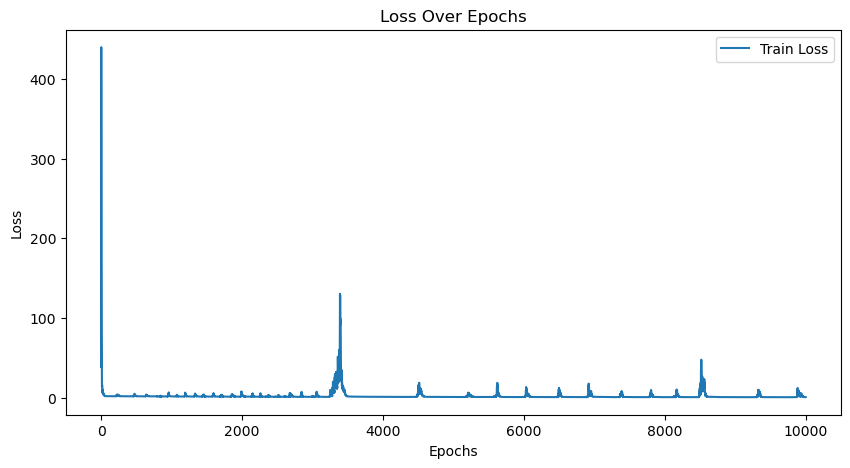

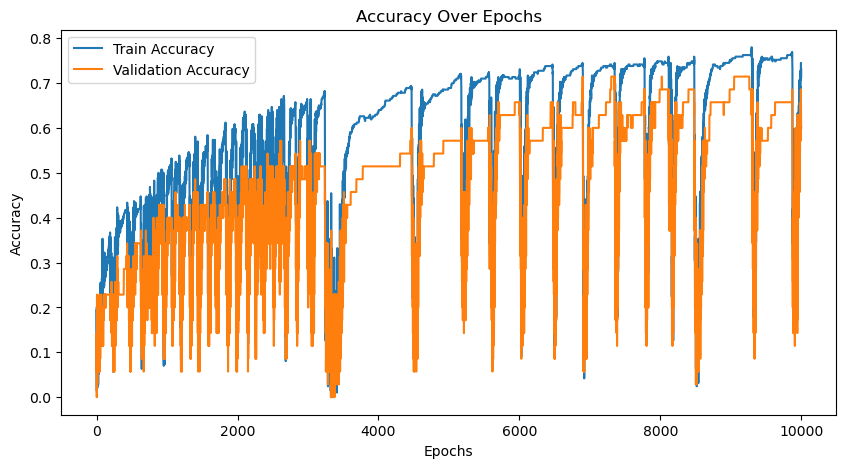

In [67]:
# Assume 'data' is your graph data object with masks and labels
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}, {torch.cuda.current_device()}')
data = data.to(device)

model = RGCN(
    num_node_features=data.num_node_features, 
    num_relations=2, 
    num_classes=len(target_cell_types) + 1, 
    edge_attr_dim=data.edge_attr.size(1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10000
# Run the training process
for epoch in tqdm(range(num_epochs)):
    loss = train()
    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    train_losses.append(loss.cpu().detach().numpy())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Evaluate on the test set
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Loss Over Epochs")
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.title("Accuracy Over Epochs")
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()